In [ ]:
#| include: false
#| default_exp kernels
from nbdev.showdoc import *
import numpy as np
import jax.numpy as jnp
from sklearn.metrics import pairwise_distances
from diffusion_curvature.datasets import paraboloid
from diffusion_curvature.utils import plot_3d
%load_ext autoreload
%autoreload 2

This notebook will establish our core utilities: functions for building the diffusion matrix, with various types of kernels.

# Kernels

In [ ]:
X, ks = paraboloid(2000)

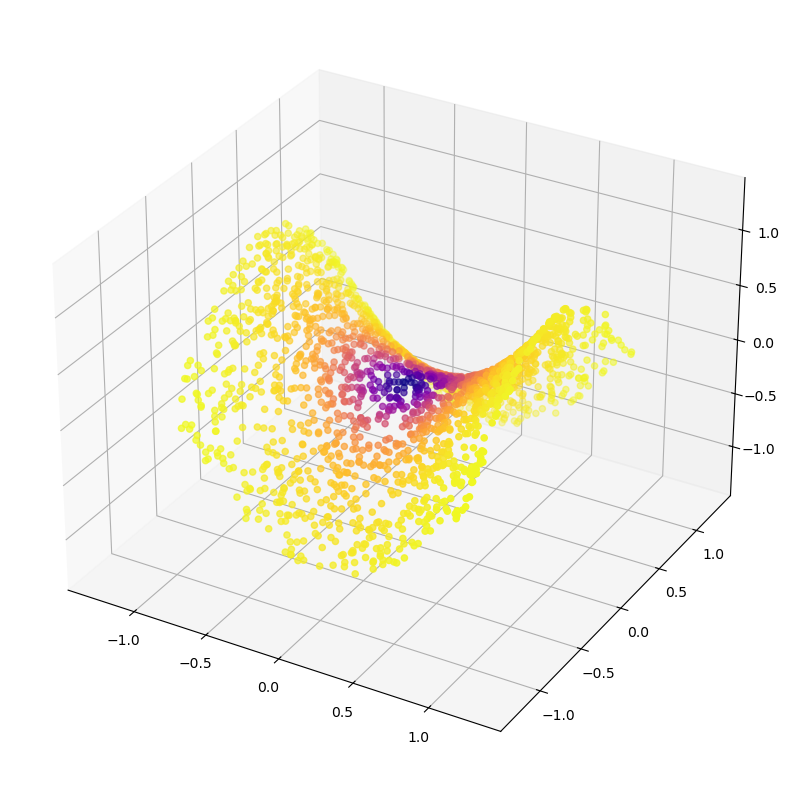

In [ ]:
plot_3d(X,ks)

## Gaussian Kernel
This currently supports either a fixed bandwidth, which applies to all points, or an adaptive bandwidth, that creates a tailor-made bandwidth for each point.

### The Median Heuristic for Kernel Bandwidth
Setting the kernel bandwidth is one of the most important operations with any kernel method. It's important to have a good heuristic to avoid needing to estimate this by trial and error. This function implements the *median heuristic* described in https://arxiv.org/pdf/1707.07269.pdf.

The median heuristic sets the bandwidth to $\sqrt{H_n/2}$, where $H_n$ is the median of the squared distances between the upper triangle of the distance matrix.

In [ ]:
#| export
import numpy as np
def median_heuristic(
        D:np.ndarray, # the distance matrix
):
    # estimate kernel bandwidth from distance matrix using the median heuristic
    # Get upper triangle from distance matrix (ignoring duplicates)
    h = D[np.triu_indices_from(D)]
    h = h**2
    h = np.median(h)
    nu = np.sqrt(h / 2)
    return nu

In [ ]:
#| export
import numpy as np
from sklearn.metrics import pairwise_distances
def gaussian_kernel(
        X:np.ndarray, # pointcloud data as rows, shape n x d
        kernel_type = "fixed", # either fixed, or adaptive
        sigma:float = 0, # if fixed, uses kernel bandwidth sigma. If not set, uses a heuristic to estimate a good sigma value
        k:float = 10, # if adaptive, creates a different kernel bandwidth for each point, based on the distance from that point to the kth nearest neighbor
        anisotropic_density_normalization:float = 0.5, # if nonzero, performs anisotropic density normalization
        threshold_for_small_values:float = 1e-5, # Sets all affinities below this value to zero. Set to zero to disable.
        neighbor_scale:float = 3.0, # if curvature agnostic, this is the scale of the neighbor distance
):
    """Constructs an affinity matrix from pointcloud data, using a gaussian kernel"""
    supported_kernel_types = {'fixed', 'adaptive', 'curvature agnostic'}
    assert kernel_type in supported_kernel_types
    D = pairwise_distances(X)
    if kernel_type == "fixed":
        if not sigma:
            # estimate sigma using a heuristic
            sigma = median_heuristic(D)
        W = (1/(sigma*np.sqrt(2*np.pi)))*np.exp((-D**2)/(2*sigma**2))
    elif kernel_type == "adaptive":
        distance_to_k_neighbor = np.partition(D,k)[:,k]
        # Populate matrices with this distance for easy division.
        div1 = np.ones(len(D))[:,None] @ distance_to_k_neighbor[None,:]
        div2 = distance_to_k_neighbor[:,None] @ np.ones(len(D))[None,:]
        # print("Distance to kth neighbors",distance_to_k_neighbor)
        # compute the gaussian kernel with an adaptive bandwidth
        W = (1/(2*np.sqrt(2*np.pi)))*(np.exp(-D**2/(2*div1**2))/div1 + np.exp(-D**2/(2*div2**2))/div2)
    elif kernel_type == "curvature agnostic":
        scaled_neighbor_dists = np.partition(D,k)[:,k]  # TODO is multiplication best here?
        sigma = np.mean(scaled_neighbor_dists) * neighbor_scale
        W = np.exp((-D**2)/sigma**2)
        # div1 = np.ones(len(D))[:,None] @ scaled_neighbor_dists[None,:]
        # div2 = scaled_neighbor_dists[:,None] @ np.ones(len(D))[None,:]
        # W = (1/(2*np.sqrt(2*np.pi)))*(np.exp(-D**2/(2*div1**2))/div1 + np.exp(-D**2/(2*div2**2))/div2)
    if anisotropic_density_normalization:
        D = np.diag(1/(np.sum(W,axis=1)**anisotropic_density_normalization))
        W = D @ W @ D
    if threshold_for_small_values:
        W[W < threshold_for_small_values] = 0
    return W

In [ ]:
#| export
import numpy as np
def compute_anisotropic_affinities_from_graph(
    W:np.ndarray, # the adjacency/affinity matrix of the graph
    alpha:float, # the anisotropic density normalization parameter
) -> np.ndarray:
    # normalize by density
    D = np.diag(1/(np.sum(W,axis=1)**alpha))
    W = D @ W @ D
    return W

def compute_anisotropic_diffusion_matrix_from_graph(
    A:np.ndarray, # the adjacency/affinity matrix of the graph
    alpha:float, # the anisotropic density normalization parameter
    ) -> np.ndarray:
    A_anis = compute_anisotropic_affinities_from_graph(A,alpha)
    # row normalize to create diffusion matrix
    D = np.diag(1/(np.sum(A_anis,axis=1)+1e-8))
    P = D @ A_anis
    return P

In [ ]:
#|export
import pygsp
def pygsp_graph_from_points(X, knn=15):
    W = gaussian_kernel(X, kernel_type="adaptive", k=knn, anisotropic_density_normalization=1)
    G = pygsp.graphs.Graph(W)
    return G

In [ ]:
#|export
def get_curvature_agnostic_graph(X, neighbor_scale = 1, k = 1, alpha = 1):
    W = gaussian_kernel(
        X, 
        kernel_type = "curvature agnostic", 
        k = k, 
        neighbor_scale=neighbor_scale, 
        anisotropic_density_normalization = alpha)
    # set diagonal of W to zero
    np.fill_diagonal(W, 0)
    G = pygsp.graphs.Graph(W)
    return G

def get_adaptive_graph(X, k = 5, alpha = 1):
    W = gaussian_kernel(
        X,
        kernel_type='adaptive',
        k = k,
        anisotropic_density_normalization = alpha,
    )
    G = pygsp.graphs.Graph(W)
    return G

def get_fixed_graph(X, sigma = 0.2, alpha = 1):
    W = gaussian_kernel(
        X, 
        kernel_type = "fixed",
        sigma = sigma,
        anisotropic_density_normalization = alpha,
    )
    # set diagonal of W to zero
    np.fill_diagonal(W, 0)
    G = pygsp.graphs.Graph(W)
    return G

# kNN Graph

In [ ]:
#|export
from sklearn.neighbors import kneighbors_graph
def get_knn_graph(
        X:np.ndarray,
        k = 10,
        alpha = 1,
        use_pygsp = True,
        self_loops = True
):
    W = kneighbors_graph(X, k, mode='connectivity', include_self=self_loops).toarray()
    if alpha > 0:
        W = compute_anisotropic_affinities_from_graph(W, alpha)
    if use_pygsp:
        G = pygsp.graphs.Graph(W)
        return G
    else:
        return W

In [ ]:
G = get_knn_graph(X)

2024-04-22 14:34:26,183:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


# Diffusion Matrix

In [ ]:
#| export
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
from graphtools.matrix import set_diagonal

def diffusion_matrix(
        X:np.ndarray = None, # pointcloud data
        A:np.ndarray = None, # adjacency matrix, if precomputed
        kernel_type:str = "fixed", # either fixed or adaptive
        sigma = 0, # if fixed, uses kernel bandwidth sigma. If not set, uses a heuristic to estimate a good sigma value
        k = 10, # if adaptive, creates a different kernel bandwidth for each point, based on the distance from that point to the kth nearest neighbor
        anisotropic_density_normalization = 0.5, # if nonzero, performs anisotropic density normalization
        threshold_for_small_values = 1e-5,
):
    """ Creates a diffusion matrix from pointcloud data, by row-normalizing the affinity matrix obtained from the gaussian_kernel function """
    if X is not None:
        W = gaussian_kernel(X,kernel_type,sigma=sigma,k = k,anisotropic_density_normalization = anisotropic_density_normalization, threshold_for_small_values=threshold_for_small_values)
        W = W + np.eye(len(X))*1e-5
    if X is None and A is not None:
        W = A
    
    K = set_diagonal(W, 1)
    P = normalize(W, norm="l1", axis=1)
    return P

In [ ]:
show_doc(diffusion_matrix)

---

### diffusion_matrix

>      diffusion_matrix (X:numpy.ndarray=None, A:numpy.ndarray=None,
>                        kernel_type:str='fixed', sigma=0, k=10,
>                        anisotropic_density_normalization=0.5,
>                        threshold_for_small_values=1e-05)

Creates a diffusion matrix from pointcloud data, by row-normalizing the affinity matrix obtained from the gaussian_kernel function

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| X | ndarray | None | pointcloud data |
| A | ndarray | None | adjacency matrix, if precomputed |
| kernel_type | str | fixed | either fixed or adaptive |
| sigma | int | 0 | if fixed, uses kernel bandwidth sigma. If not set, uses a heuristic to estimate a good sigma value |
| k | int | 10 | if adaptive, creates a different kernel bandwidth for each point, based on the distance from that point to the kth nearest neighbor |
| anisotropic_density_normalization | float | 0.5 | if nonzero, performs anisotropic density normalization |
| threshold_for_small_values | float | 1e-05 |  |

# Exploration of different kernel functions

In [ ]:
X = np.random.rand(5,5)
D = pairwise_distances(X)
D

array([[0.        , 1.04834717, 1.02125719, 0.78966412, 1.12007887],
       [1.04834717, 0.        , 1.37914641, 0.4507077 , 0.80511447],
       [1.02125719, 1.37914641, 0.        , 1.11119637, 1.14925453],
       [0.78966412, 0.4507077 , 1.11119637, 0.        , 0.8135576 ],
       [1.12007887, 0.80511447, 1.14925453, 0.8135576 , 0.        ]])

In [ ]:
# Get the distance to the kth closest neighbor
distance_to_k_neighbor = np.partition(D,2)[:,2]
# [:,2] # argpartition is more efficient than argsort ([python - How to get indices of top-K values from a numpy array - Stack Overflow](https://stackoverflow.com/questions/65038206/how-to-get-indices-of-top-k-values-from-a-numpy-array))
distance_to_k_neighbor

array([1.02125719, 0.80511447, 1.11119637, 0.78966412, 0.8135576 ])

Double checking that the code for the adaptive kernel works as intended:

In [ ]:
div2 = distance_to_k_neighbor[:,None] @ np.ones(len(D))[None,:]
div2

array([[1.02125719, 1.02125719, 1.02125719, 1.02125719, 1.02125719],
       [0.80511447, 0.80511447, 0.80511447, 0.80511447, 0.80511447],
       [1.11119637, 1.11119637, 1.11119637, 1.11119637, 1.11119637],
       [0.78966412, 0.78966412, 0.78966412, 0.78966412, 0.78966412],
       [0.8135576 , 0.8135576 , 0.8135576 , 0.8135576 , 0.8135576 ]])

In [ ]:
div1 = np.ones(len(D))[:,None] @ distance_to_k_neighbor[None,:]
div1

array([[1.02125719, 0.80511447, 1.11119637, 0.78966412, 0.8135576 ],
       [1.02125719, 0.80511447, 1.11119637, 0.78966412, 0.8135576 ],
       [1.02125719, 0.80511447, 1.11119637, 0.78966412, 0.8135576 ],
       [1.02125719, 0.80511447, 1.11119637, 0.78966412, 0.8135576 ],
       [1.02125719, 0.80511447, 1.11119637, 0.78966412, 0.8135576 ]])

Let's chart the torus with several different diffusion kernels.

In [ ]:
from diffusion_curvature.datasets import torus

In [ ]:
X, ks = torus(n=2000)

In [ ]:
X

array([[-1.64230755, -2.50365593, -0.10718602],
       [ 0.93114739, -2.29736884,  0.87787014],
       [-0.63171354,  1.24202019,  0.79503802],
       ...,
       [-1.31606593, -0.43307043,  0.78890819],
       [ 0.66324638,  0.92663171, -0.50951108],
       [-2.37836633,  1.7184788 ,  0.35663094]])

To visualize this, we'll build a 3D plot helper, to save time in the future

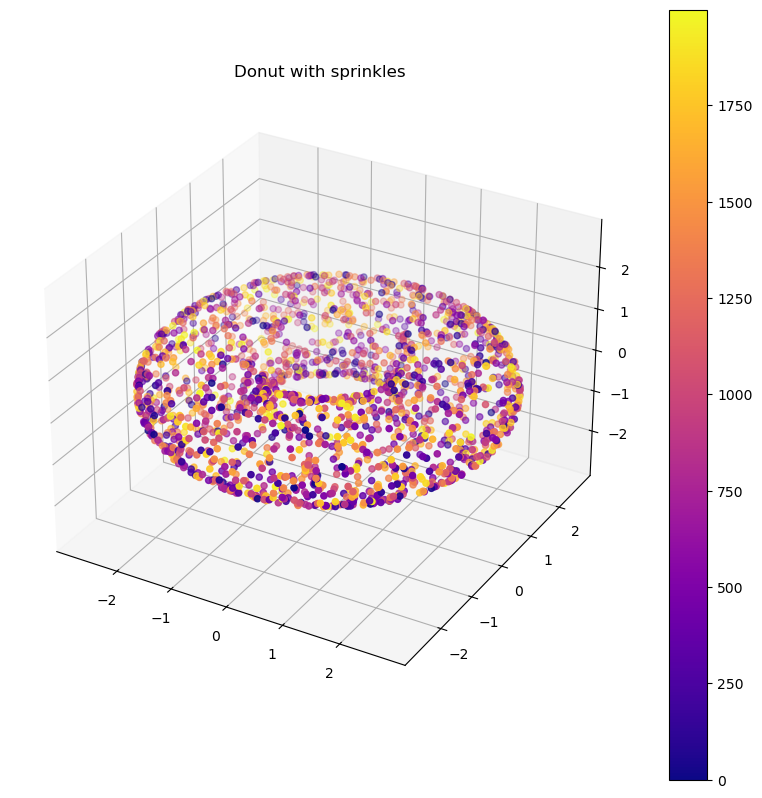

In [ ]:
plot_3d(X,list(range(len(X))),"Donut with sprinkles",colorbar = True)

Hurrah! Our donut is intact, and our plotting function is working as expected.

Now let's visualize some diffusions, under various kernels.

## The Adaptive Kernel

Here we have the adaptive kernel born Diffusion matrix, and we visualize the diffusion centered on the point (0,-3,0), which (from the view of the plot below), should be on the outer rim of the torus, facing us directly.

In [ ]:
P = diffusion_matrix(X,kernel_type="adaptive",k=20)

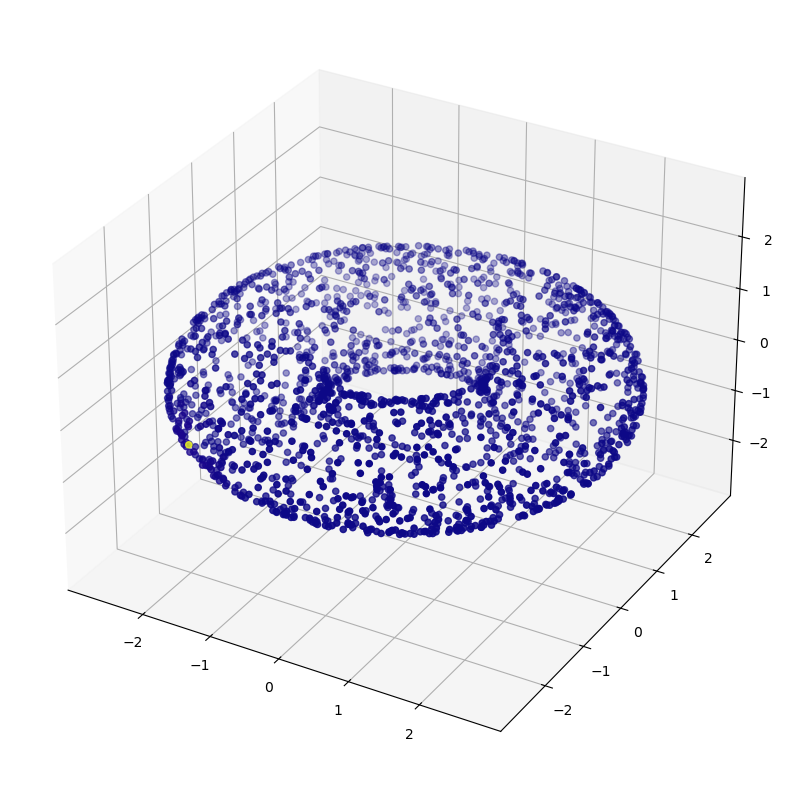

In [ ]:
dist = P[0]
plot_3d(X,dist)

## The Adaptive Anisotropic Kernel

Now we'll add one more round of density normalization with the "adaptive anisotropic" kernel:
$$ W_{a} = D^{-1} W D^{-1} $$
Where D is the matrix whose diagonals are the rowsums of W.

In [ ]:
P = diffusion_matrix(X,kernel_type="adaptive",k=20,anisotropic_density_normalization=1)

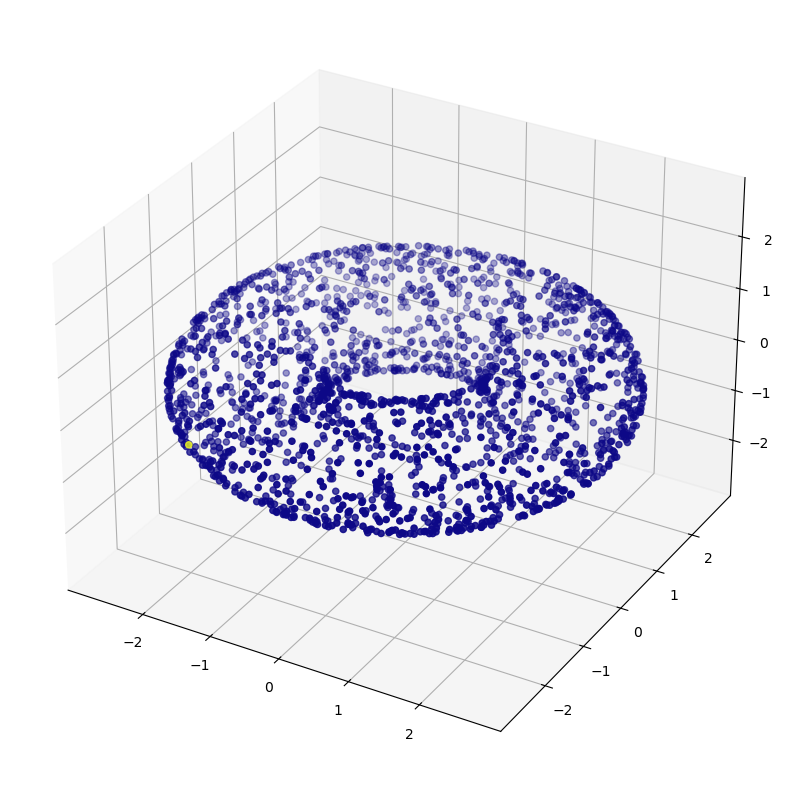

In [ ]:
dist = P[0]
plot_3d(X,dist)

It looks much the same, as expected. Ideally, this kernel will combat density related differences in the curvature, by equalizing the density.

In [ ]:
from diffusion_curvature.datasets import sphere

In [ ]:
X, ks = sphere(2000)

In [ ]:
A = gaussian_kernel(X,kernel_type = "adaptive", k = 10, anisotropic_density_normalization = 1, threshold_for_small_values=1e-5)

In [ ]:
A

array([[1.08247698e-03, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 7.00504770e-04, 0.00000000e+00, ...,
        0.00000000e+00, 1.73628856e-05, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 6.77552510e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.02046253e-04, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.73628856e-05, 0.00000000e+00, ...,
        0.00000000e+00, 9.01614875e-04, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 7.50943242e-04]])

In [ ]:
sum(A)

array([0.01800834, 0.01630736, 0.01647122, ..., 0.01707931, 0.01694614,
       0.01481187])

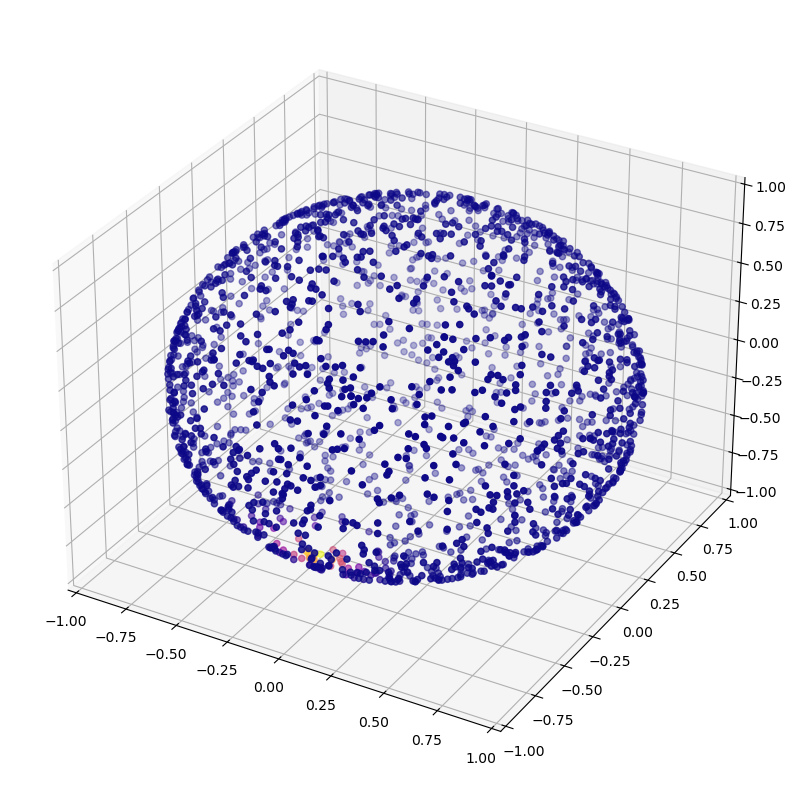

In [ ]:
plot_3d(X,A[0])

## The Curvature Agnostic Kernel

In [ ]:
A = gaussian_kernel(X, kernel_type = "curvature agnostic", k=4, neighbor_scale=1)

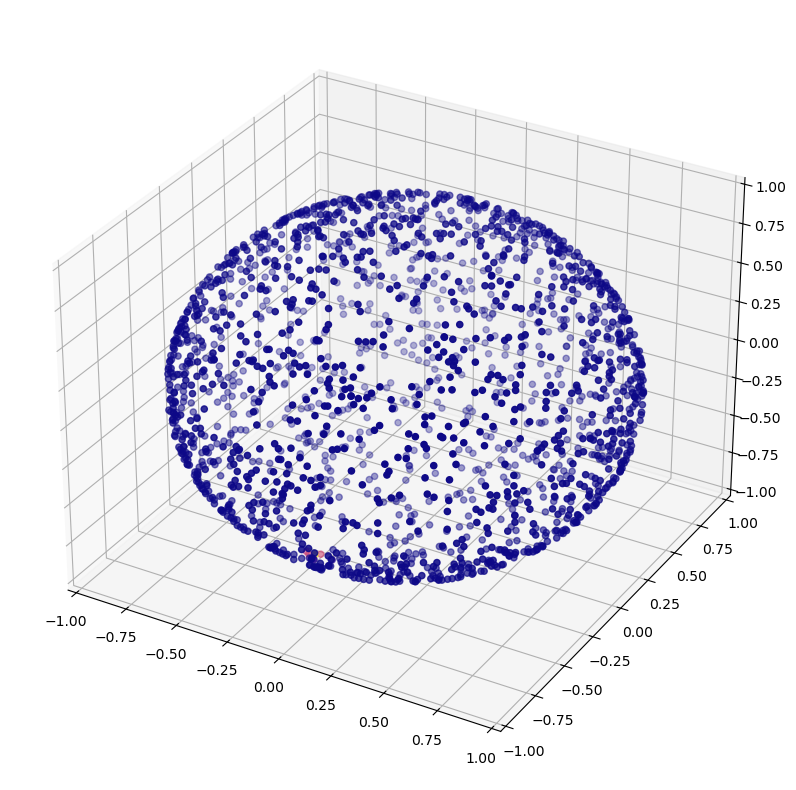

In [ ]:
plot_3d(X,A[0])

# Testing

## kNN Graph

In [ ]:
from diffusion_curvature.datasets import torus
from diffusion_curvature.heat_diffusion import jax_power_matrix

In [ ]:
X, ks = torus(2000, use_guide_points = True)
A = get_knn_graph(X,k=10, use_pygsp=False, alpha=0)
P = diffusion_matrix(A = A)
Pt = jax_power_matrix(jnp.asarray(P),20)
plot_3d(X, Pt[0])

2024-04-22 14:34:38.687877: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 15.26MiB (rounded to 16000000)requested by op 
2024-04-22 14:34:38.687975: W external/tsl/tsl/framework/bfc_allocator.cc:497] <allocator contains no memory>


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16000000 bytes.

In [ ]:
A

In [ ]:
P

In [ ]:
!nbdev_export